
# Trabalho Prático de Algorítmos 2




**Membros integrantes do grupo:**

>-Caio Teles Cunha - 2020006434 

>-Ivan - 2021421931

>-Henrique Rotsen Santos Ferreira - 2020100945

# **Introdução**

  Nesse trabalho foi solicitado a implementação um algoritmo para criar modelos de classificação em aprendizado supervisionado. O modelo de classificação solicitado deverá ajustar modelos lineares para os dados e fará uso de diversos algoritmos de geometria computacional vistos em sala de aula.


# **Verificação de separabilidade linear dos dados**

Primeiramente, deve-se verificar a separabilidade linear dos dados. Nesse trabalho nossas amostras serão pontos no plano cartesiano, ou seja, duas variáveis descrevem as amostras. Para isso precisamos calcular as envoltórias convexas de cada classe, também assumiremos que os dados possuem apenas dois rótulos, e posteriormente verificar se existe sobreposição dessas envoltórias. Caso não haja sobreposição, os dados são linearmente separáveis.

# **Criação da função que computa as envoltárias convexas**

> Escolhemos fazer o algoritmo da envoltória de Graham. Primeiramente, ordenamos o vetor de pontos em relação ao y e, em caso de empate, utilizamos o x. O motivo dessa ordenação está em encontrar o ponto com o menor y e mais à esquerda, pois esse ponto com certeza pertence à envoltória. Então escolhemos esse ponto como âncora e fazemos uma nova ordenação dos pontos em relação a ele, usando as primitivas vistas em sala, de modo à ordenar os pontos em sentido anti-horário em relação ao âncora.

> Então, a partir do âncora, percorremos o vetor de pontos verificando se existe uma curva para a direita ou para a esquerda, atráves do produto vetorial, a cada ponto inserido e definimos dessa forma se o ponto faz ou não parte da envoltória.

In [6]:
# Importando bibliotecas.
import matplotlib.pyplot as plt
import random
import numpy as np
import sys
import math   
import pandas as pd
from itertools import combinations
from functools import cmp_to_key
!pip install pytrees
from pytrees import AVLTree

In [7]:
# Algumas definicoes para melhor visualizacao dos dados

plt.rcParams['figure.figsize'] = (16, 10)

plt.rcParams['axes.axisbelow'] = True 
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.ymargin'] = 0.1

plt.rcParams['font.family'] = 'serif'

plt.rcParams['grid.color'] = 'lightgrey'
plt.rcParams['grid.linewidth'] = .1

plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.direction'] = 'out' 
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 6
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.minor.visible'] = True

plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 6
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['legend.fontsize'] = 16

plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 4

plt.style.use('tableau-colorblind10')
plt.ion();

**Definição das classes `Ponto` e `Segmento`**.

In [8]:
# Primeiramente definimos a classe Ponto
class Ponto:
  def __init__(self,x,y):
    self.x = x
    self.y = y

  def __sub__(self,b):
    x = self.x - b.x
    y = self.y - b.y
    return Ponto(x,y)

  def __repr__(self): 
    return "(% s, % s)" % (self.x, self.y)

  # Aqui sobrecarregamos o operador de < para funcionar para pontos
  def __lt__(self, other):
    if self.y < other.y:
      return True

    if self.y == other.y and self.x < other.x:
      return True
      
    return False

class Segmento:
    def __init__(self, pontoEsquerdo, pontoDireito, poligonoID):
        self.pontoEsquerdo = pontoEsquerdo
        self.pontoDireito = pontoDireito
        a = (pontoDireito.y - pontoEsquerdo.y)/(pontoDireito.x - pontoEsquerdo.x)
        b = (pontoEsquerdo.y - a * pontoEsquerdo.x)
        # a -> coeficiente angular, b -> coeficiente linear
        self.chave = (a, b)
        # 0 representa um polígono, 1 representa o outro
        self.poligonoID = poligonoID 

    def __repr__(self): 
        return "(% s, % s, % s)" % (self.pontoEsquerdo, self.pontoDireito,self.chave)

**Criamos um vetor de pontos aleatórios para os testes.**

In [9]:
def geraPts(x0, x1, y0, y1, n):
  pVec = []
  for x in range(n):
    m = random.randint(x0,x1)
    n = random.randint(y0,y1)
    
    a = Ponto(m,n)
    pVec.append(a)
  return pVec

In [10]:
pVec = geraPts(-50, -10, -50, -10, 100)

**Visualizando os pontos**

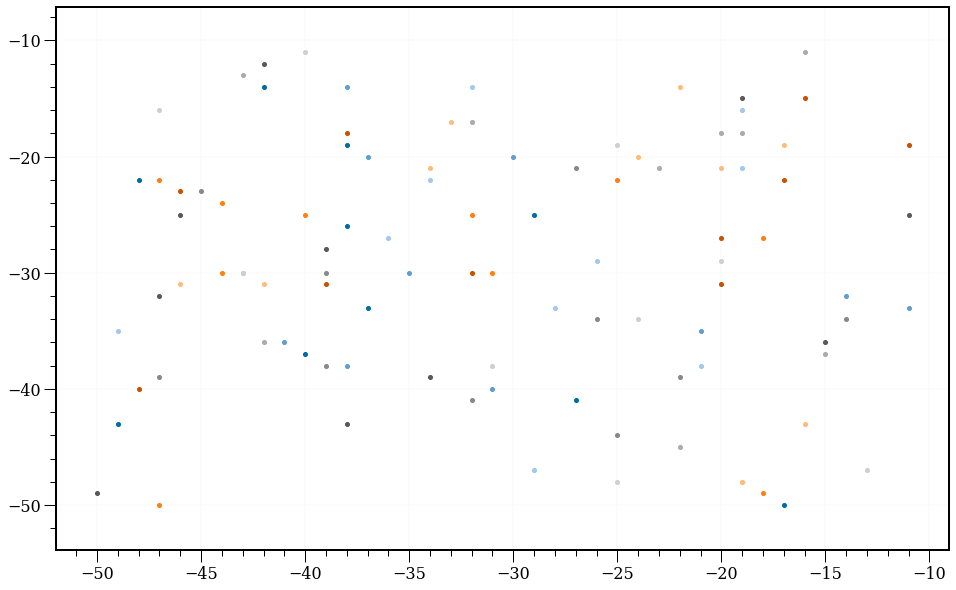

In [11]:
# Plotamos todos os pontos
for x in pVec:
  plt.scatter(x.x,x.y)

>`pVec[0]` sempre terá o valor de menor y mais a esquerda, após a ordenação usando a função sort do python no vetor de pontos. Como provado em sala, esse ponto sempre pertence à envoltória, então escolheremos ele como âncora para o algoritmo.

**Algoritimo de Graham**

In [12]:
# Função auxiliar para quando existirem pontos colineares saber qual escolher
def distSq(p1, p2):
    return ((p1.x - p2.x) * (p1.x - p2.x) + (p1.y - p2.y) * (p1.y - p2.y))

# Testa se existe e qual é a curva entre os vetores formados pelo ancora e os pontos
def direcaoSeg(p, p1, p2):
  val = ((p1.y - p.y) * (p2.x - p1.x) -
        (p1.x - p.x) * (p2.y - p1.y))
  if val == 0:
      return 0  # colineares
  elif val > 0:
      return 1  # sentido horario
  else:
      return 2  # sentido anti-horario

def EnvoltoriaDeGrahm(points, n):

    points.sort()
    # Definimos o âncora
    Ancora = points[0]
    PontosEnvoltoria = []

    # Função de comparação para ordenação dos pontos
    def Compara(p1,p2):
      curva = direcaoSeg(Ancora,p1,p2)
      if curva == 0:
        if distSq(Ancora,p2) >= distSq(Ancora,p1):
          return -1
        else:
          return 1
      else:
        if curva == 2:
          return -1
        else:
          return 1


    # Ordenar pelo angulo polar
    points = sorted(points, key=cmp_to_key(Compara))

    # Remover pontos colineares menos distantes 
    m = 1 
    for i in range(1, n):
        while ((i < n-1) and (direcaoSeg(Ancora, points[i], points[i + 1]) == 0)):
            i += 1
        points[m] = points[i]
        m += 1 
   
    PontosEnvoltoria = []
    PontosEnvoltoria.append(points[0])
    PontosEnvoltoria.append(points[1])
    PontosEnvoltoria.append(points[2])
 
    for i in range(3, m):
        while ((len(PontosEnvoltoria) > 1) and (direcaoSeg(PontosEnvoltoria[-2], PontosEnvoltoria[-1], points[i]) != 2)):
            PontosEnvoltoria.pop()
        PontosEnvoltoria.append(points[i])
 
    return PontosEnvoltoria

**Função para construir os segmentos das nossas envoltórias**

In [13]:
def construtorSeg(pontos, poligonoID):
  seg = []
  for i in range(len(pontos)):
    if i+1 < len(pontos):  
        if pontos[i].x ==  pontos[i+1].x:
            pontos[i].x += 0.0001
            seg.append(Segmento(pontos[i], pontos[i+1], poligonoID))
        else:
            seg.append(Segmento(pontos[i], pontos[i+1], poligonoID))
    else:
        if pontos[i].x ==  pontos[0].x:
            pontos[i].x += 0.0001
            seg.append(Segmento(pontos[0], pontos[i], poligonoID))
        else:
            seg.append(Segmento(pontos[0], pontos[i], poligonoID))
  return seg

## Para visualizar a Envoltória

O valor do *Âncora* deve sempre ser o `pVec[0]`, para cada envoltória.

In [14]:
n = len(pVec)

In [15]:
env1 = EnvoltoriaDeGrahm(pVec, n)

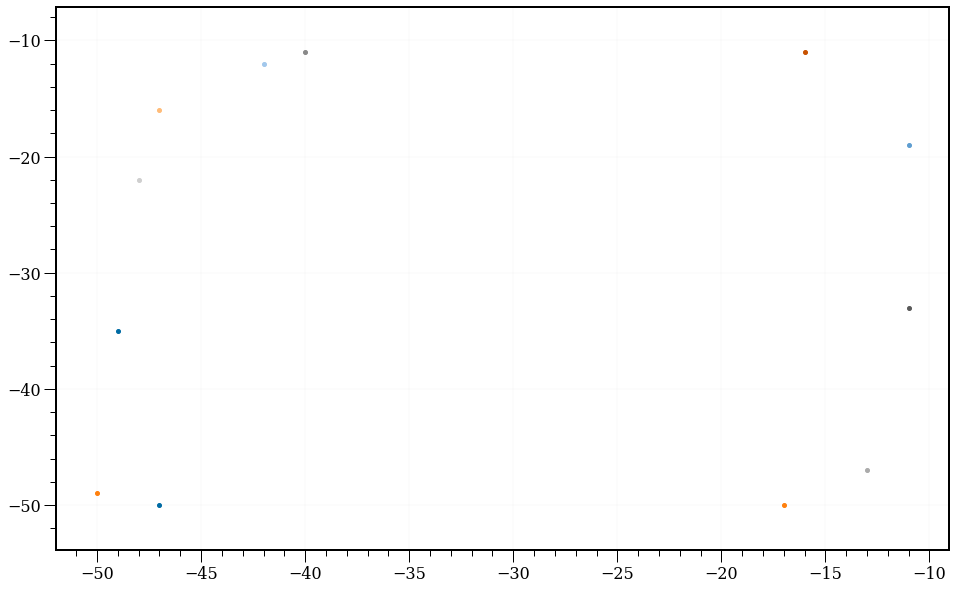

In [16]:
for x in env1:
  plt.scatter(x.x, x.y)

**Gerando os segmentos que compõem a nossa Envoltória**

In [17]:
Seg1 = construtorSeg(env1, 0)

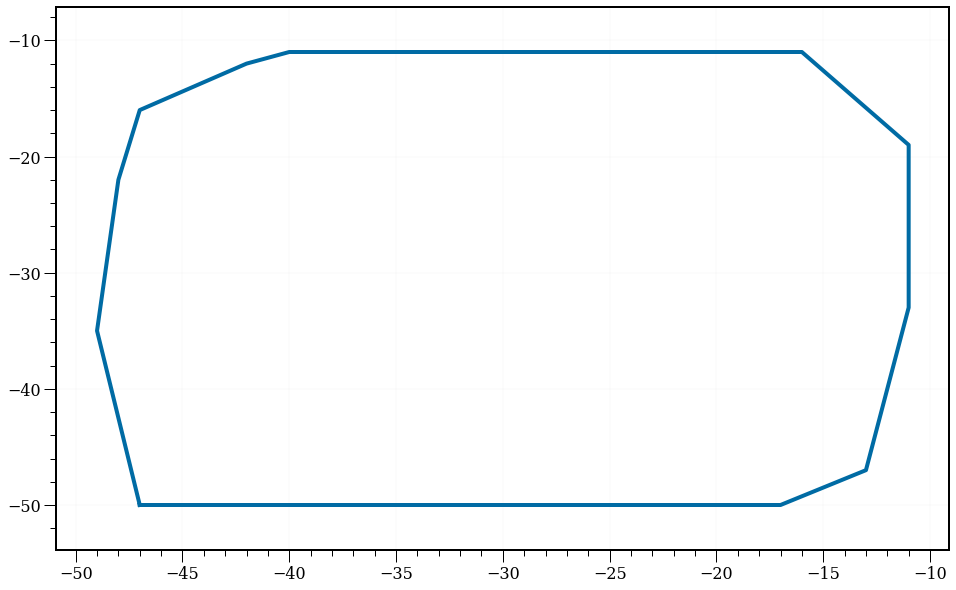

In [18]:
figurefig, ax = plt.subplots()

xSeg1 = []
ySeg1 = []
for x in Seg1:
  xSeg1.append(x.pontoEsquerdo.x)
  ySeg1.append(x.pontoEsquerdo.y)

xSeg1.append(Seg1[0].pontoEsquerdo.x)
ySeg1.append(Seg1[0].pontoEsquerdo.y)

ax.plot(xSeg1, ySeg1, '-')
plt.show()

# **Checando se uma envoltória está dentro da outra**

 A primeira checagem que fazemos para verificar a separabilidade linear dos dados é conferir se uma envoltória está interna a outra, caso isto ocorra temos dados que não separáveis. Se não estiverem contidas uma na outra, executamos a varradura para captar possíveis interseções.

# **Varredura Linear**

### Funções auxiliares


In [19]:
# Checa se o ponto 1 está dentro do segmento dado por ponto1 e ponto3
def pontoNoSegmento(ponto1, ponto2, ponto3):
    if ((ponto2.x) <= max(ponto1.x, ponto3.x) and (ponto2.x) >= min(ponto1.x, ponto3.x) and
            (ponto2.y) <= max(ponto1.y, ponto3.y) and (ponto2.y) >= min(ponto1.y, ponto3.y)):
        return True
    return False

def intersecaoSeg(seg1,seg2):
    # Condição para impedir a checagem de interseção de segmentos do mesmo polígono
    if seg1.poligonoID == seg2.poligonoID:
        return False

    ponto1 = seg1.pontoEsquerdo
    ponto2 = seg1.pontoDireito
    ponto3 = seg2.pontoEsquerdo
    ponto4 = seg2.pontoDireito

    d1 = direcaoSeg(ponto3, ponto4, ponto1)
    d2 = direcaoSeg(ponto3, ponto4, ponto2)
    d3 = direcaoSeg(ponto1, ponto2, ponto3)
    d4 = direcaoSeg(ponto1, ponto2, ponto4)

    if ((d1 != d2 and d3 != d4)):
        return True

    # Casos onde um segmento tem um de seus pontos finais no outro
    if (d1 == 0 and pontoNoSegmento(ponto3, ponto1, ponto4)):
        return True

    if (d2 == 0 and pontoNoSegmento(ponto3, ponto2, ponto4)):
        return True

    if (d3 == 0 and pontoNoSegmento(ponto1, ponto3, ponto2)):
        return True

    if (d4 == 0 and pontoNoSegmento(ponto1, ponto4, ponto2)):
        return True

    return False

Utilizaremos a varredura para checar se duas envoltórias se interceptam e checar sua separabilidade.

Inicialmente implementamos 2 funções, a principal delas checa se 2 segmentos se interceptam, nela utilizamos uma outra que confere se um dos pontos finais de um segmento está contido no outro e também a função definida anteriormente de ver a orientação de um ponto em relação a um segmento. 

In [20]:
def envDentroEnv(seg1, seg2):
    intersecoes = 0

    if (seg1[0].pontoEsquerdo > seg2[0].pontoEsquerdo):
        # Traçar uma reta de um ponto ao infinito e contar interseções
        for n in range(len(seg2)):
            if (intersecaoSeg(Segmento(seg1[0].pontoEsquerdo, Ponto(sys.maxsize, seg1[0].pontoEsquerdo.y ), 1), seg2[n])):
                intersecoes += 1
    else:
        # Traçar uma reta de um ponto ao infinito e contar interseções
        for n in range(len(seg1)):
            if (intersecaoSeg(Segmento(seg2[0].pontoEsquerdo, Ponto(sys.maxsize, seg2[0].pontoEsquerdo.y ), 1), seg1[n])):
                intersecoes += 1

    # Se tiver um número par de interseções está fora, ímpar está dentro
    if (intersecoes % 2 == 0):
        return False
    else:
        return True

### Classes necessárias

Precisamos criar a classe Evento que conterá todos os pontos terminais dos segmentos (pontos de início e de fim). Nela fazemas uma sobrecarga de operador para que possamos ordenar seus elementos priorizando a coordenada x dos pontos e usando a o fato de ser ponto de início e o valor de y como desempate.

Na implementação da varredura, utilizamos uma árvore AVL para armazenar os segmentos, pertencente a biblioteca *pytrees*. Mas foi necessário definir uma nova classe nó que tivesse 2 elementos a coordenada x no momento de inserção e também o segmento inserido. 

Nela realizamos sobrecargas para fazer com que as operações realizadas na árvore sejam feitas com y do segmento, o qual é obtido com a tupla de coeficientes que todo Segmento possui, com base no x atual da reta de varredura no momento da operação. Isto é um dos fatores fundamentais para este algoritmo, pois garante que a posição dos segmentos sofra alterações enquanto a reta de varredura prossegue no plano.

In [21]:
class Evento:
    def __init__(self, x, y, pontoInicial, index):
        self.x = x 
        self.y = y 
        # Booleano que indica se é um ponto de início ou final
        self.pontoInicial = pontoInicial
        # Variável auxiliar para ajudar na busca na árvore de eventos
        self.index = index

    def __lt__(self, other):
        if (self.x < other.x):
            return True

        if (self.x == other.x):
            if self.pontoInicial == True and other.pontoInicial == False:
                return True
            if self.pontoInicial == False and other.pontoInicial == True:
                return False
            else:
                return self.y < other.y

        if (self.x > other.x): 
            return False
        else:
            return self.y > other.y

class Nodo:
    def __init__(self, x, segmento):
        # Adicionamos um pequeno valor para tratar segmentos com igual ponto de início
        self.x = x + 0.000001 
        self.segmento = segmento
    
    def __lt__(self, other):
        return ((self.segmento.chave[0] * self.x) + self.segmento.chave[1]) < ((other.segmento.chave[0] * other.x) + other.segmento.chave[1])
    
    def __le__(self, other):
        return ((self.segmento.chave[0] * self.x) + self.segmento.chave[1]) <= ((other.segmento.chave[0] * other.x) + other.segmento.chave[1])
    
    def __eq__(self,other):
        if self.segmento.chave[0] == other.segmento.chave[0] and self.segmento.chave[1] == other.segmento.chave[1]:
            return True

    def __gt__(self, other):
       return ((self.segmento.chave[0] * self.x) + self.segmento.chave[1]) > ((other.segmento.chave[0] * other.x) + other.segmento.chave[1])

    def __ge__(self, other):
        return ((self.segmento.chave[0] * self.x) + self.segmento.chave[1]) >= ((other.segmento.chave[0] * other.x) + other.segmento.chave[1])

### Função de varredura de seguimentos

Agora podemos partir para o algoritmo da varredura em si. Utilizamos duas estruturas para ele: uma árvore AVL (importada da biblioteca *pytree*) que armazena o conjunto de seguimentos "ativos" e de uma lista para armazenar todos os eventos de forma ordenada para que possamos varrê-los da esquerda para direita. 

Ele utiliza duas funções auxiliares que percorrem a árvore para encontrar os segmentos consecutivos de um segmento e, assim, poder checar se eles se interceptam. Estas são chamadas em todo evento que ocorre, retornando True caso eles se interceptem e terminando o algoritmo.

O algoritmo recebe duas listas de segmentos que representam duas envoltórias que representam 2 conjuntos de dados e checa interseções entre elas. No nosso contexto, no caso de haver esse encontro de envoltórias concluímos que estes dados não são linearmente separáveis, se não houver eles são.

In [22]:
# Busca o vizinho superior do segmento atual
def acima(arvore, nodo): 
    nodo = arvore.search(nodo)
    if (nodo == None):
        return None
    nodoPai = nodo.parent

    if(nodo.right != None):
        return nodo.right
    else:
        if(nodo.parent != None and nodo.parent.left == nodo):
            return nodo.parent

        while(nodoPai != None):
            if (nodoPai.val > nodo.val):
                return nodoPai
            else:
                nodoPai = nodoPai.parent
        return None

# Busca o vizinho inferior do segmento atual
def abaixo(arvore, nodo):
    nodo = arvore.search(nodo)
    if (nodo == None):
        return None
    nodoPai = nodo.parent

    if(nodo == None): 
        return nodo

    if(nodo.left != None):
        return nodo.left
    else:
        if(nodo.parent != None and nodo.parent.right == nodo):
            return nodo.parent

        while(nodoPai != None):
            if (nodoPai.val < nodo.val):
                return nodoPai
            else:
                nodoPai = nodoPai.parent
        return None


def varreduraSeg(seg1, seg2):
    segmentos = seg1 + seg2
    eventos = []
    
    # Inserindo os pontos terminais(eventos) de todos os seguimentos
    for n in range(len(segmentos)):
        eventos.append(Evento(segmentos[n].pontoEsquerdo.x, segmentos[n].pontoEsquerdo.y, True, n))
        eventos.append(Evento(segmentos[n].pontoDireito.x, segmentos[n].pontoDireito.y, False, n))
    
    eventos.sort()
    arvore = AVLTree()

    for p in eventos:
        if p.pontoInicial == True:
            arvore.insert(Nodo(p.x, segmentos[p.index]))
            nodoAcima = acima(arvore, Nodo(p.x, segmentos[p.index]))
            nodoAbaixo = abaixo(arvore, Nodo(p.x, segmentos[p.index]))

            # Checando intercessão entre os segmentos adjacentes ao inserido
            if((nodoAcima != None and intersecaoSeg(segmentos[p.index], nodoAcima.val.segmento))
                or nodoAbaixo != None and intersecaoSeg(segmentos[p.index], nodoAbaixo.val.segmento)):
                return True

        if p.pontoInicial == False:
            nodoAcima = acima(arvore, Nodo(p.x, segmentos[p.index]))
            nodoAbaixo = abaixo(arvore, Nodo(p.x, segmentos[p.index]))

            # Checando intercessão entre os segmentos que tornaram-se vizinho após a remoção
            if(nodoAcima != None and nodoAbaixo != None and intersecaoSeg(nodoAcima.val.segmento, nodoAbaixo.val.segmento)):
                return True

            arvore.delete(Nodo(p.x, segmentos[p.index]))

    return False

# **Classificador**

Fazemos uma segunda envoltória para ajudar na demonstração

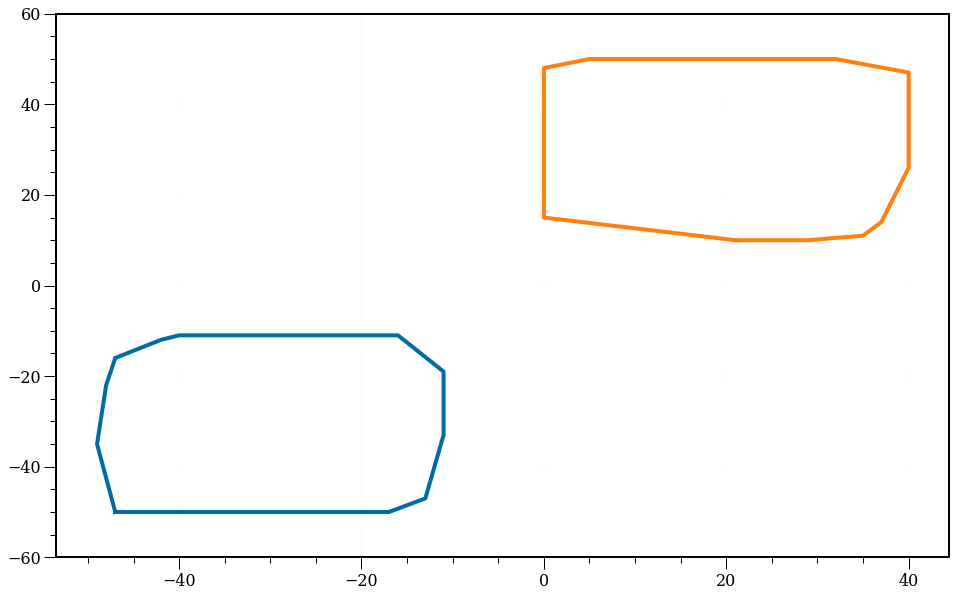

In [23]:
figurefig, ax = plt.subplots()

# Gera vetor de pontos
pVec = geraPts(0, 40, 10, 50, 100)

#Gera envoltória
env2 = EnvoltoriaDeGrahm(pVec, n)

#Gera segmentos da segunda envoltória
Seg2 = construtorSeg(env2, 1)

xSeg1 = []
ySeg1 = []
for x in Seg1:
  xSeg1.append(x.pontoEsquerdo.x)
  ySeg1.append(x.pontoEsquerdo.y)

xSeg1.append(Seg1[0].pontoEsquerdo.x)
ySeg1.append(Seg1[0].pontoEsquerdo.y)


xSeg2 = []
ySeg2 = []
for x in Seg2:
  xSeg2.append(x.pontoEsquerdo.x)
  ySeg2.append(x.pontoEsquerdo.y)

xSeg2.append(Seg2[0].pontoEsquerdo.x)
ySeg2.append(Seg2[0].pontoEsquerdo.y)

ax.plot(xSeg1, ySeg1, '-')
ax.plot(xSeg2, ySeg2, '-')
plt.show()

## Agora vamos achar:
>A **Distância Mínima** entre as 2 envoltórias

>O **Ponto Médio** entre as 2 envoltórias

> E uma **Reta** dividindo essas 2 envoltórias. 

> **Intervalo** de X que contém as 2 envoltórias



Distância Mínima

In [24]:
def minDist(env1, env2):
  minDis = distSq(env1[0], env2[0])
  k = 0
  l = 0
  for i in range(len(env1)):
    for j in range(len(env2)):
      helper = distSq(env1[i], env2[j])
      if (minDis > helper):
        minDis = helper
        k = i
        l = j
  return env1[k], env2[l]

In [25]:
ptMinDist1, ptMinDist2 = minDist(env1, env2)

Ponto Médio

In [26]:
def pontoMedio(ptMinDist1, ptMinDist2):
  xMedio = (ptMinDist1.x + ptMinDist2.x)/2
  yMedio = (ptMinDist1.y + ptMinDist2.y)/2
  pMedio = Ponto(xMedio, yMedio)
  return pMedio

In [27]:
pMedio = pontoMedio(ptMinDist1, ptMinDist2)

Reta que divide as 2 envoltórias

In [28]:
def retaDiv(ptMinDist1, ptMinDist2, pMedio, xMin, xMax):
  # Reta de menor distância que liga as 2 envoltórias
  xRetaMin = [ptMinDist1.x, ptMinDist2.x]
  yRetaMin = [ptMinDist1.y, ptMinDist2.y]


  deltaX = (ptMinDist2.x - ptMinDist1.x)
  if (deltaX == 0):
    deltaX += 0.0001
    
  # Coeficiente ângular da reta perpedicular     
  alpha = (ptMinDist2.y - ptMinDist1.y)/deltaX
  if (alpha == 0):
    alpha += 0.0001

  invAlpha = -1/alpha

  # Coeficiente linear da reta perpendicular
  beta = -(invAlpha * pMedio.x) + pMedio.y

  # Criando segmento contido na reta do modelo
  y = (invAlpha * (pMedio.x + 50)) + beta
  segRetaPerp = Segmento(Ponto(50, y), pMedio, 3) 

  # Um arranjo de pontos x para criar a reta perpendicular
  f = np.arange(math.floor(xMin), math.ceil(xMax) + 1, 1)

  # Equação do Modelo
  eqModelo = (invAlpha * f) - (invAlpha * pMedio.x) + pMedio.y
  return eqModelo, f, segRetaPerp, invAlpha

Intervalo de X

In [29]:
def getMinMax(env1, env2):
  xMin = env1[0].x
  for i in range(len(env1)):
    if xMin > env1[i].x:
      xMin = env1[i].x

  xMax = env2[0].x
  for i in range(len(env2)):
    if xMax < env2[i].x:
      xMax = env2[i].x
  return math.floor(xMin), math.ceil(xMax)

Agora vamos plotar o que fizemos

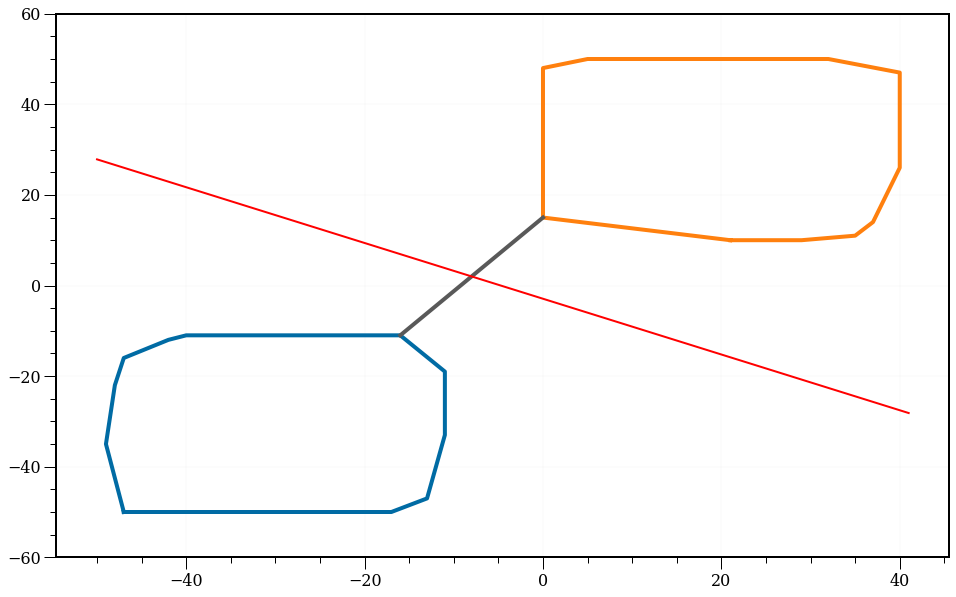

In [30]:
fig, ax = plt.subplots()

xSeg1 = []
ySeg1 = []
for n in Seg1:
  xSeg1.append(n.pontoEsquerdo.x)
  ySeg1.append(n.pontoEsquerdo.y)

xSeg1.append(Seg1[0].pontoEsquerdo.x)
ySeg1.append(Seg1[0].pontoEsquerdo.y)


xSeg2 = []
ySeg2 = []
for n in Seg2:
  xSeg2.append(n.pontoEsquerdo.x)
  ySeg2.append(n.pontoEsquerdo.y)

xSeg2.append(Seg2[0].pontoEsquerdo.x)
ySeg2.append(Seg2[0].pontoEsquerdo.y)

xMin, xMax = getMinMax(env1, env2)
eqModelo, f, segRetaPerp, invAlpha = retaDiv(ptMinDist1, ptMinDist2, pMedio, xMin, xMax)

# Reta de menor distância que liga as 2 envoltórias
xRetaMin = [ptMinDist1.x, ptMinDist2.x]
yRetaMin = [ptMinDist1.y, ptMinDist2.y]

ax.plot(xSeg1, ySeg1, '-')
ax.plot(xSeg2, ySeg2, '-')
ax.plot(pMedio.x, pMedio.y, '.')
ax.plot(xRetaMin, yRetaMin, '-')
ax.plot(f, eqModelo, '-', c='red', linewidth=2)
plt.show()

Então implementaremos o classificador de forma que todos os pontos acima da reta vermelha pertencerão à classe dos pontos da envoltória de cor laranja e todos os pontos abaixo da reta pertencerão a classe dos pontos da envoltória azul.

## Fazendo a função classificadora


Na classificação, vamos ver a orientação de todos os pontos em relação a um segmento pertencente a reta perpendicular achada acima. Um ponto estará em uma das duas regiões do plano caso esteja em sentido anti-horário em relação ao segmento, na outra caso esteja em sentido horário e em nenhuma caso seja colinear ao segmento. Sendo que cada região corresponde a um rótulo possível para a nova amostra.

In [31]:
def classificador(pontos, segReta):
    ptsRot0 = []
    ptsRot1 = []
    ptsRot2 = []

    for n in range(len(pontos)):
      direcao = direcaoSeg(pontos[n], segReta.pontoEsquerdo, segReta.pontoDireito)

      if (direcao == 1):
        ptsRot1.append(pontos[n]) # sentido horario
      elif (direcao == 2):
        ptsRot2.append(pontos[n]) # sentido anti-horario
      else:
        ptsRot0.append(pontos[n])  # colineares

    return ptsRot0, ptsRot1, ptsRot2 

ptsSort = geraPts(-80,50,-80,50, 100)
ptsRot0, ptsRot1, ptsRot2 = classificador(ptsSort, segRetaPerp)

Abaixo temos uma visualização gráfica do nosso classificador. 

Sendo a reta perpendicular encontrada anteriormente nosso modelos, os pontos em laranja os que possuem Rótulo A recebendo o mesmo rótulo da envoltória laranja mostrada acima e os azuis pontos com o rótulo da envoltória de mesma cor presente acima. Também há pontos pretos em cima da reta do modelo, estes não recebem rótulos.

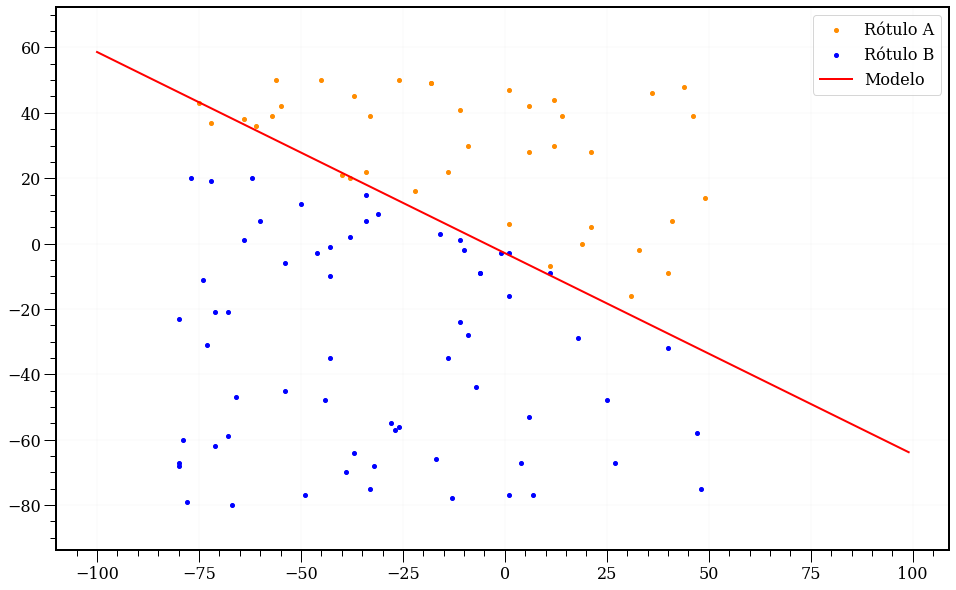

In [32]:
# Um arranjo de pontos x para criar a reta perpendicular
f = np.arange(-100,100,1)

# Equação do Modelo
eqModelo = (invAlpha * f) - (invAlpha * pMedio.x) + pMedio.y

fig, ax = plt.subplots()

xRot0 = []
yRot0 = []
for n in ptsRot0:
  xRot0.append(n.x)
  yRot0.append(n.y)

if len(ptsRot0) != 0:
  xRot0.append(ptsRot0[0].x)
  yRot0.append(ptsRot0[0].y)

xRot1 = []
yRot1 = []
for n in ptsRot1:
  xRot1.append(n.x)
  yRot1.append(n.y)

xRot1.append(ptsRot1[0].x)
yRot1.append(ptsRot1[0].y)

xRot2 = []
yRot2 = []
for n in ptsRot2:
  xRot2.append(n.x)
  yRot2.append(n.y)

xRot2.append(ptsRot2[0].x)
yRot2.append(ptsRot2[0].y)

plt.scatter(xRot0, yRot0, c='black')
plt.scatter(xRot1, yRot1, c='darkorange', label='Rótulo A')
plt.scatter(xRot2, yRot2, c='blue', label='Rótulo B')
ax.plot(f, eqModelo, '-', linewidth=2, c='red', label='Modelo')
plt.legend()
plt.show()

# Modelagem

Com tudo pronto e funcionando, agora testaremos nosso classificador em diversos bancos de dados para avaliar sua eficiência na tarefa. Usaremos a biblioteca pandas para facilitar a visualização das tabelas. Os datasets serão modificados para o propósito do trabalho, sempre avaliaremos apenas duas classes e dois atributos.

Essa função recebe o dataset filtrado pela classe, as colunas que serão usadas no eixo x e y, e o número da envoltória retornando o conjunto de pontos que formam a envoltória.

In [33]:
def EvoltoriaDaClasse(dfClasse,colunaX,colunaY):
  listaX = dfClasse[colunaX].tolist()
  listaY = dfClasse[colunaY].tolist()

  listaDePontos = []
  for x,y in zip(listaX,listaY):
    listaDePontos.append(Ponto(x,y))

  envoltoria = EnvoltoriaDeGrahm(listaDePontos, len(listaDePontos))
  return envoltoria

Função para calcular a métrica precisão

In [34]:
#formula VP/VP+FP
#vp = verdadeiros positivos
#fp = falsos positivos
def calculaPrecisao(segRetaPerp,df_teste,ClasseDireita,ClasseEsquerda,colunaX,colunaY):
  vp = 0
  fp = 0
  dfDireita = df_teste.query("Class == @ClasseDireita")
  dfEsquerda = df_teste.query("Class == @ClasseEsquerda")

  #fazendo o da direita, ou seja, sentido horário em relação a reta
  #considerarei a direita positivo e esquerda negativo
  listaX = dfDireita[colunaX].tolist()
  listaY = dfDireita[colunaY].tolist()

  listaDePontos = []
  for x,y in zip(listaX,listaY):
    listaDePontos.append(Ponto(x,y))
  
  ptsRot0, ptsRot1, ptsRot2 = classificador(listaDePontos, segRetaPerp)
  vp = len(ptsRot1)

  #fazendo para esquerda
  listaX = dfEsquerda[colunaX].tolist()
  listaY = dfEsquerda[colunaY].tolist()

  listaDePontos = []
  for x,y in zip(listaX,listaY):
    listaDePontos.append(Ponto(x,y))
  
  ptsRot0, ptsRot1, ptsRot2 = classificador(listaDePontos, segRetaPerp)
  fp = len(ptsRot1)

  den = vp + fp
  if den == 0:
    return "impossível identificar"
  else:
    return vp/den

Função para calcular a métrica revocação

In [35]:
#formula VP/VP+FN
#vp = verdadeiros positivos
#fn = falsos negativos
def calculaRevocacao(segRetaPerp,df_teste,ClasseDireita,ClasseEsquerda,colunaX,colunaY):
  vp = 0
  fn = 0
  dfDireita = df_teste.query("Class == @ClasseDireita")
  dfEsquerda = df_teste.query("Class == @ClasseEsquerda")

  #fazendo o da direita, ou seja, sentido horário em relação a reta
  #considerarei a direita positivo e esquerda negativo
  listaX = dfDireita[colunaX].tolist()
  listaY = dfDireita[colunaY].tolist()

  listaDePontos = []
  for x,y in zip(listaX,listaY):
    listaDePontos.append(Ponto(x,y))
  
  ptsRot0, ptsRot1, ptsRot2 = classificador(listaDePontos, segRetaPerp)
  vp = len(ptsRot1)
  fn = len(ptsRot2)

  den = vp + fn
  if den == 0:
    return "impossível identificar"
  else:
    return vp/den

Função para calcular a métrica F1-Score

In [36]:
def f1score(precisao,revocacao):
  return ((2*precisao*revocacao)/(precisao+revocacao))

Função auxiliar para plotar a envoltória

In [37]:
def plotaEnvoltoria(env):
  figurefig, ax = plt.subplots()

  xSeg1 = []
  ySeg1 = []
  for x in env:
    xSeg1.append(x.x)
    ySeg1.append(x.y)

  xSeg1.append(env[0].x)
  ySeg1.append(env[0].y)

  ax.plot(xSeg1, ySeg1, '-')
  plt.show()

# Iris DataSet

Importamos um dataset sobre iris do https://sci2s.ugr.es/keel/category.php?cat=clas#inicio


In [38]:
import pandas as pd

# Importando o arquivo .csv do dataset
url = 'https://raw.githubusercontent.com/IvanAssis07/TP_ICD/main/iris.csv'
df = pd.read_csv(url)
df.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


A primeira coisa que devemos fazer é separar o grupo de treinamento do modelo e o grupo de teste

In [39]:
df_teste = df.sample(frac = 0.3)
df_treino = df.drop(df_teste.index)

Como no nosso trabalho estamos avaliando apenas dados que possuem duas classes, modificamos o banco de dados para conter apenas duas classes de iris. Também vamos retirar duas das colunas, pois queremos avaliar um atributo apenas por eixo. Usaremos SepalLength como a variável para o eixo x e PetalLength como variável para o eixo y.

Para a primeira classe:

In [40]:
df_setosa = df_treino.query('Class == "Iris-setosa"')
df_setosa.head(5)

,SepalLength,SepalWidth,PetalLength,PetalWidth,Class
1,4.9,3.0,1.4,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa
5,4.6,3.4,1.4,0.3,Iris-setosa
6,5.0,3.4,1.5,0.2,Iris-setosa


In [41]:
df_setosa = df_setosa.drop(labels=['SepalWidth', 'PetalWidth'], axis=1)
df_setosa.head(5)

,SepalLength,PetalLength,Class
1,4.9,1.4,Iris-setosa
3,5.0,1.4,Iris-setosa
4,5.4,1.7,Iris-setosa
5,4.6,1.4,Iris-setosa
6,5.0,1.5,Iris-setosa


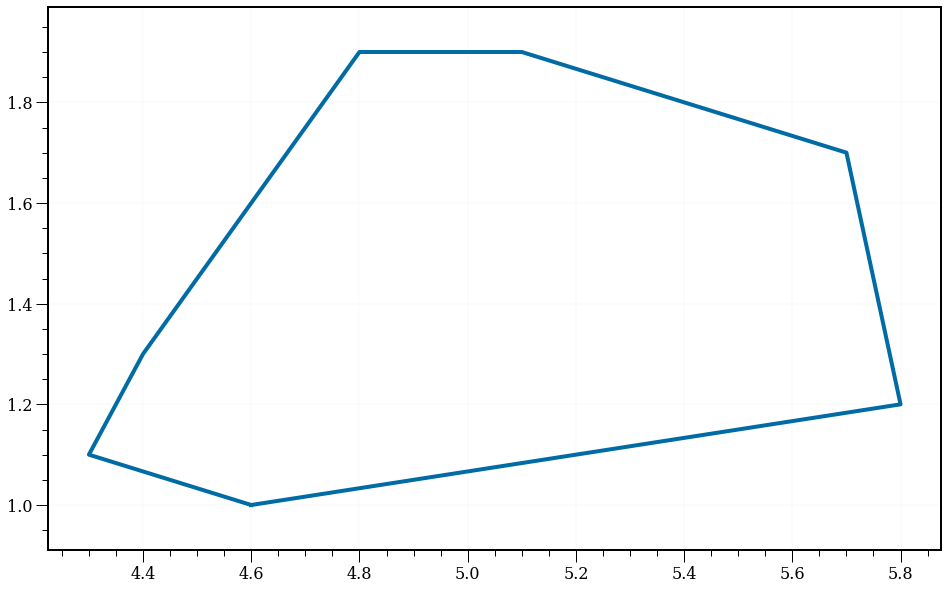

In [42]:
env1 = EvoltoriaDaClasse(df_setosa,'SepalLength','PetalLength')
plotaEnvoltoria(env1)

Para a segunda classe:

In [43]:
df_virginica = df_treino.query('Class == "Iris-virginica"')
df_virginica = df_virginica.drop(labels=['SepalWidth', 'PetalWidth'], axis=1)

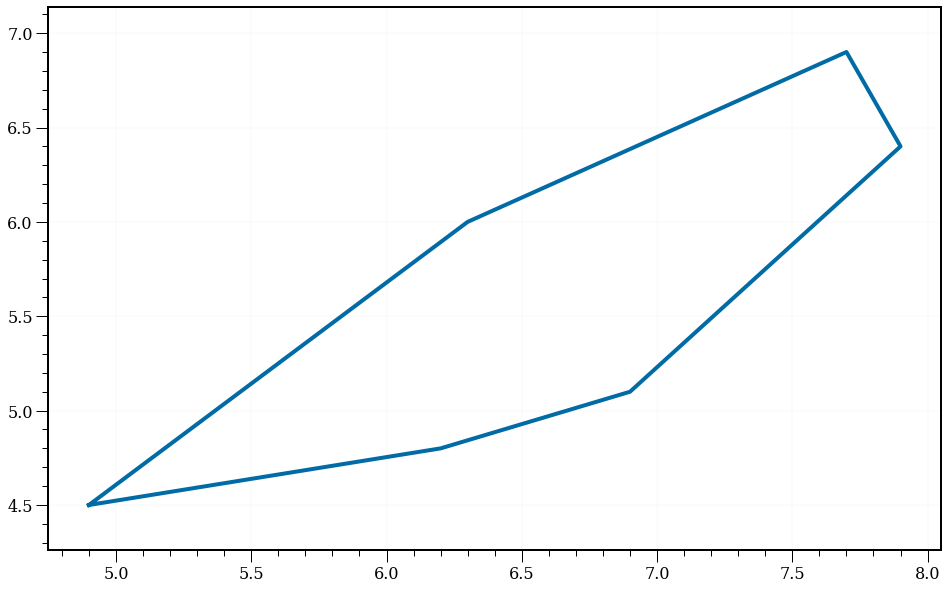

In [44]:
env2 = EvoltoriaDaClasse(df_virginica,'SepalLength','PetalLength')
plotaEnvoltoria(env2)

Agora precisamos chegar se essas classes são linearmente separáveis.


In [45]:
# Criamos os segmentos para as envoltórias
Seg1 = construtorSeg(env1, 0)
Seg2 = construtorSeg(env2, 1)

# Checamos se uma está dentro da outra
if envDentroEnv(Seg1, Seg2):
  print("Uma envoltória é subconjunto da outra")
else:
  print("envoltórias separadas")

envoltórias separadas


Como uma envoltória não está contida na outra vamos avaliar se existe interseção entre elas

In [46]:
if varreduraSeg(Seg1, Seg2):
  print("dados não são linearmente separáveis")
else:
  print("dados linearmente separáveis")

dados linearmente separáveis


Como os dados são linearmente separáveis podemos computar a reta do classificador

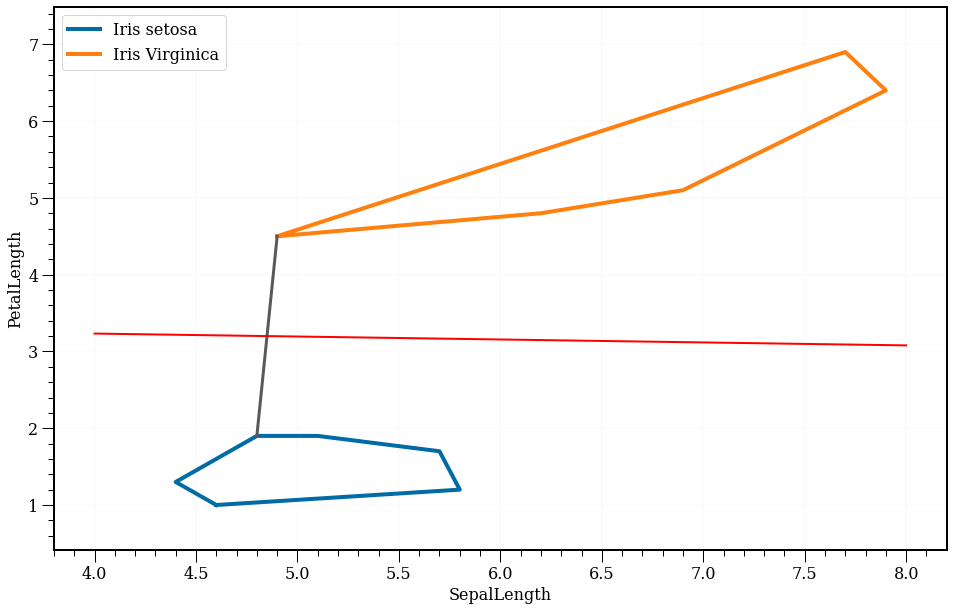

In [47]:
from cProfile import label


fig, ax = plt.subplots()

xSeg1 = []
ySeg1 = []
for n in Seg1:
  xSeg1.append(n.pontoEsquerdo.x)
  ySeg1.append(n.pontoEsquerdo.y)

xSeg1.append(Seg1[0].pontoEsquerdo.x)
ySeg1.append(Seg1[0].pontoEsquerdo.y)


xSeg2 = []
ySeg2 = []
for n in Seg2:
  xSeg2.append(n.pontoEsquerdo.x)
  ySeg2.append(n.pontoEsquerdo.y)

xSeg2.append(Seg2[0].pontoEsquerdo.x)
ySeg2.append(Seg2[0].pontoEsquerdo.y)

# Gerando nossa reta perpendicular
ptMinDist1, ptMinDist2 = minDist(env1, env2)
pMedio = pontoMedio(ptMinDist1, ptMinDist2)
xMin, xMax = getMinMax(env1, env2)
eqModelo, f, segRetaPerp, invAlpha = retaDiv(ptMinDist1, ptMinDist2, pMedio, xMin, xMax)

# Reta de menor distância que liga as 2 envoltórias
xRetaMin = [ptMinDist1.x, ptMinDist2.x]
yRetaMin = [ptMinDist1.y, ptMinDist2.y]

ax.plot(xSeg1, ySeg1, '-', label='Iris setosa')
ax.plot(xSeg2, ySeg2, '-', label='Iris Virginica')
ax.plot(pMedio.x, pMedio.y, '.')
ax.plot(xRetaMin, yRetaMin, '-', linewidth=3)
ax.plot(f, eqModelo, '-', c='red', linewidth=2)
plt.xlabel('SepalLength')
plt.ylabel('PetalLength')
plt.legend()
plt.show()

Agora vamos calcular as métricas para avaliação do modelo. No caso a envoltória da direita da reta é a envoltória 2.

In [48]:
print("A precisão do modelo é: ")
pre = calculaPrecisao(segRetaPerp,df_teste,"Iris-virginica","Iris-setosa",'SepalLength','PetalLength')
print(pre)

A precisão do modelo é: 
1.0


In [49]:
print("A revocação do modelo é: ")
rev = calculaRevocacao(segRetaPerp,df_teste,"Iris-virginica","Iris-setosa",'SepalLength','PetalLength')
print(rev)

A revocação do modelo é: 
1.0


In [50]:
print("o f1-score do modelo é:")
f1 = f1score(pre,rev)
print(f1)

o f1-score do modelo é:
1.0


No caso todas as nossas métricas receberam a pontuação mais alta, isso significa que o nosso modelo tem grandes chances de se adequar perfeitamente aos dados.

# Generalização do classificador para qualquer dataset

A seguir criamos duas funções que concatenam várias outras desenvolvidas acima para checar a separabilidade linear de um dataset. A função **_checaSeparalidade_** realiza todas as combinações 2 a dois dos atributos do dataset fornecido e também das possíveis classes que cada instância do dataset pode assumir. Ela usa essas combinações para checar a existência de dados linearmente separáveis e, caso sejam, é chamada a função **_reta classificador_** que plota estes estes dados e também o modelo criado a partir deles.

In [51]:
def retaClassificadora(seg1, seg2, env1, env2, classes, atributos, dfTeste):
  fig, ax = plt.subplots()

  xSeg1 = []
  ySeg1 = []
  for n in seg1:
    xSeg1.append(n.pontoEsquerdo.x)
    ySeg1.append(n.pontoEsquerdo.y)

  xSeg1.append(seg1[0].pontoEsquerdo.x)
  ySeg1.append(seg1[0].pontoEsquerdo.y)


  xSeg2 = []
  ySeg2 = []
  for n in seg2:
    xSeg2.append(n.pontoEsquerdo.x)
    ySeg2.append(n.pontoEsquerdo.y)

  xSeg2.append(seg2[0].pontoEsquerdo.x)
  ySeg2.append(seg2[0].pontoEsquerdo.y)

  # Gerando nossa reta perpendicular
  ptMinDist1, ptMinDist2 = minDist(env1, env2)
  pMedio = pontoMedio(ptMinDist1, ptMinDist2)
  xMin, xMax = getMinMax(env1, env2)
  eqModelo, f, segRetaPerp, invAlpha = retaDiv(ptMinDist1, ptMinDist2, pMedio, xMin, xMax)

  prec = calculaPrecisao(segRetaPerp, dfTeste, classes[0], classes[1], atributos[0], atributos[1])
  rev = calculaRevocacao(segRetaPerp, dfTeste, classes[0], classes[1], atributos[0], atributos[1])
  f1 = f1score(prec, rev)

  print('A precisão é:' + str(prec))
  print('A revocacao do modelo é:' + str(rev))
  print('O F1Score do modelo é:' + str(f1))

  # Reta de menor distância que liga as 2 envoltórias
  xRetaMin = [ptMinDist1.x, ptMinDist2.x]
  yRetaMin = [ptMinDist1.y, ptMinDist2.y]

  ax.plot(xSeg1, ySeg1, '-', label=classes[0])
  ax.plot(xSeg2, ySeg2, '-', label=classes[1])
  ax.plot(pMedio.x, pMedio.y, '.')
  ax.plot(xRetaMin, yRetaMin, '-', linewidth=3)
  ax.plot(f, eqModelo, '-', c='red', linewidth=2)
  plt.xlabel(atributos[0])
  plt.ylabel(atributos[1])
  plt.legend()
  plt.show()



In [52]:
def checaSeparalidade(df, dfTeste, classe):
    atributos = df.columns.tolist()
    atributos.remove(classe)

    combAtributos = list(combinations(atributos, 2))

    classes = df[classe].unique()

    combClasses = list(combinations(classes, 2))

    for n in combAtributos:
        dfAtributos = df.loc[:,[n[0], n[1], classe]]
        for i in combClasses:
            dfClasse1 = dfAtributos.loc[dfAtributos[classe] == i[0]]
            dfClasse2 = dfAtributos.loc[dfAtributos[classe] == i[1]]

            envoltoria1 = EvoltoriaDaClasse(dfClasse1, n[0], n[1])
            envoltoria2 = EvoltoriaDaClasse(dfClasse2, n[0], n[1])

            # Criamos os segmentos para as envoltórias
            segmentos1 = construtorSeg(envoltoria1, 0)
            segmentos2 = construtorSeg(envoltoria2, 1)

            # Checamos se uma está dentro da outra
            if  envDentroEnv(segmentos1, segmentos2) or (varreduraSeg(segmentos1, segmentos2)):
                continue
            else:
                print(n[0] + " e " + n[1] +" são dados linearmente separáveis\n")
                return retaClassificadora(segmentos1, segmentos2, envoltoria1, envoltoria2, i, n, dfTeste)

    print("Os dados não são linearmente separáveis")

**Iris Dataset**

In [53]:
# Importando o arquivo .csv do dataset
url = 'https://raw.githubusercontent.com/IvanAssis07/TP_ICD/main/iris.csv'
df = pd.read_csv(url)
df.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


SepalLength e SepalWidth são dados linearmente separáveis

A precisão é:1.0
A revocacao do modelo é:0.9285714285714286
O F1Score do modelo é:0.962962962962963


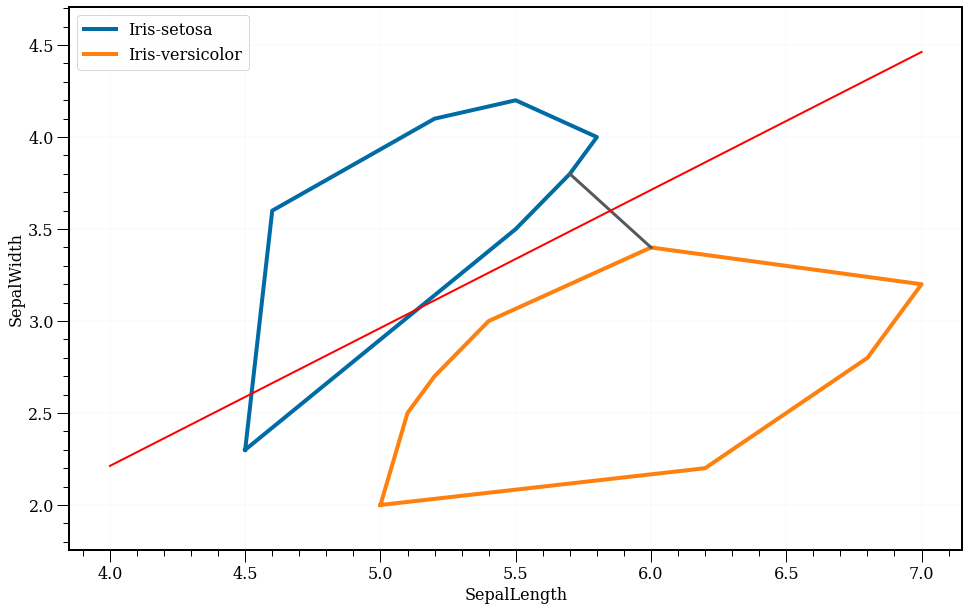

In [54]:
#separando o treio e amostra
dfTeste = df.sample(frac = 0.3)
dfTreino = df.drop(df_teste.index)

checaSeparalidade(dfTreino, dfTeste, 'Class')

**Ring Dataset**

In [55]:
# Importando o arquivo .csv do dataset
url = 'https://raw.githubusercontent.com/IvanAssis07/TP_ICD/main/ring.csv'
df = pd.read_csv(url)
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A12,A13,A14,A15,A16,A17,A18,A19,A20,Class
0,849.0,2177.0,598.0,1689.0,3114.0,-3406.0,3799.0,-2642.0,1578.0,-181.0,...,1633.0,4664.0,1081.0,-1172.0,-166.0,578.0,1664.0,309.0,-3028.0,0
1,947.0,543.0,782.0,-449.0,-8.0,1316.0,756.0,-61.0,1604.0,1686.0,...,-382.0,1259.0,608.0,-2292.0,1008.0,2687.0,-1422.0,-606.0,2374.0,1
2,759.0,-314.0,898.0,-1743.0,2003.0,1117.0,911.0,136.0,-489.0,-144.0,...,112.0,598.0,474.0,2026.0,1431.0,-336.0,79.0,1123.0,302.0,1
3,531.0,1374.0,517.0,1226.0,1122.0,-4.0,-1227.0,2277.0,1083.0,888.0,...,1063.0,2454.0,587.0,-744.0,1216.0,916.0,-476.0,6.0,-477.0,1
4,-1443.0,1065.0,2071.0,207.0,-865.0,-786.0,2655.0,-366.0,971.0,-341.0,...,4195.0,-117.0,-2694.0,14.0,4097.0,1356.0,-944.0,-602.0,2348.0,0


A1 e A2 são dados linearmente separáveis

A precisão é:0.3387096774193548
A revocacao do modelo é:0.21019108280254778
O F1Score do modelo é:0.25940482874789444


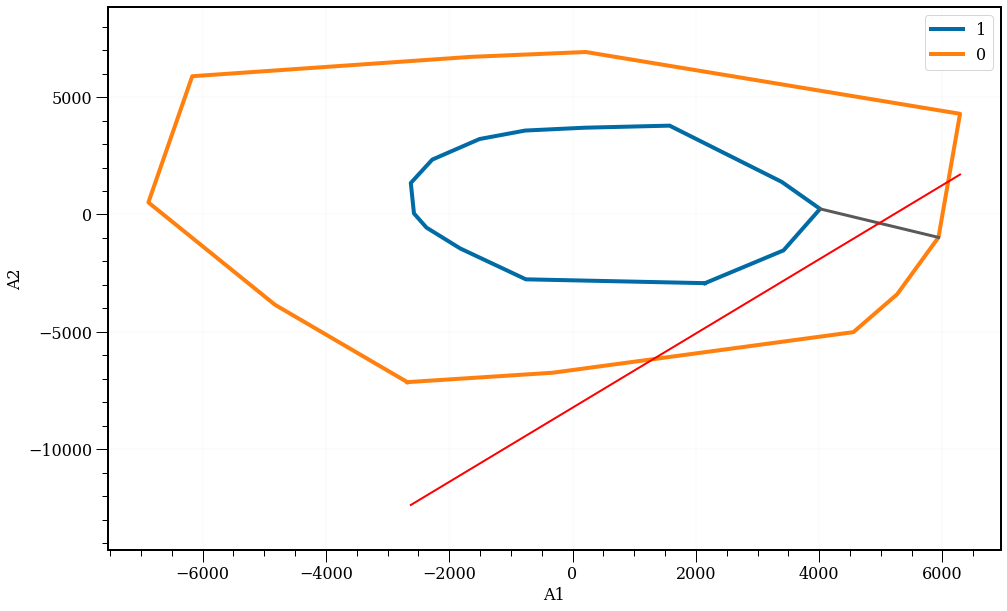

In [56]:
#separando o treio e amostra
dfTeste = df.sample(frac = 0.3)
dfTreino = df.drop(df_teste.index)
checaSeparalidade(dfTreino, dfTeste, 'Class')

**Hayes roth dataset**

In [57]:
# Importando o arquivo .csv do dataset
url = 'https://raw.githubusercontent.com/IvanAssis07/TP_ICD/main/hayes-roth.csv'
df = pd.read_csv(url)
df.head()

,Hobby,Age,EducationalLevel,MaritalStatus,Class
0,2,1,1,2,1
1,2,1,3,2,2
2,3,1,4,1,3
3,2,4,2,2,3
4,1,1,3,4,3


In [58]:
#separando o treio e amostra
dfTeste = df.sample(frac = 0.3)
dfTreino = df.drop(df_teste.index)
checaSeparalidade(dfTreino, dfTeste, 'Class')

Os dados não são linearmente separáveis


**Titanic dataset**

In [59]:
# Importando o arquivo .csv do dataset
url = 'https://raw.githubusercontent.com/IvanAssis07/TP_ICD/main/titanic.csv'
df = pd.read_csv(url)
df.head()

,Class,Age,Sex,Survived
0,-1.8700,-0.228,0.521,-1.0
1,-0.9230,-0.228,-1.920,1.0
2,-0.9230,-0.228,-1.920,1.0
3,0.9650,-0.228,0.521,1.0
4,0.0214,-0.228,0.521,-1.0


In [60]:
#separando o treio e amostra
dfTeste = df.sample(frac = 0.3)
dfTreino = df.drop(df_teste.index)
checaSeparalidade(dfTreino, dfTeste, 'Survived')

Os dados não são linearmente separáveis


**Page blocks dataset**

In [61]:
# Importando o arquivo .csv do dataset
url = 'https://raw.githubusercontent.com/IvanAssis07/TP_ICD/main/page-blocks.csv'
df = pd.read_csv(url)
df.head()

,Height,Lenght,Area,Eccen,P_black,P_and,Mean_tr,Blackpix,Blackand,Wb_trans,Class
0,5,7,35,1.400,0.400,0.657,2.33,14,23,6,1
1,6,7,42,1.167,0.429,0.881,3.60,18,37,5,1
2,6,18,108,3.000,0.287,0.741,4.43,31,80,7,1
3,5,7,35,1.400,0.371,0.743,4.33,13,26,3,1
4,6,3,18,500.000,0.500,0.944,2.25,9,17,4,1


Height e Lenght são dados linearmente separáveis

A precisão é:0.5
A revocacao do modelo é:0.34375
O F1Score do modelo é:0.4074074074074074


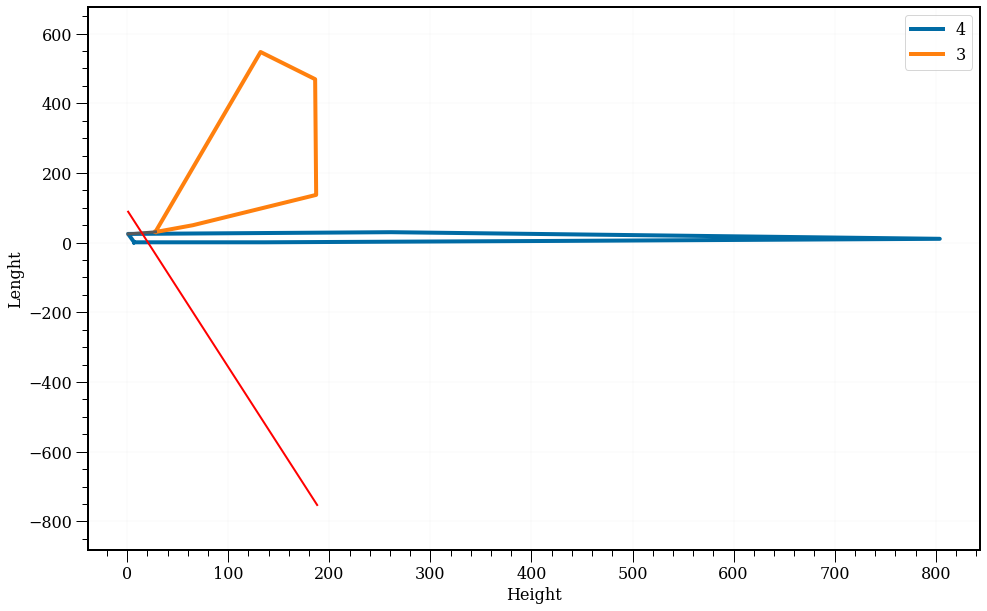

In [62]:
#separando o treio e amostra
dfTeste = df.sample(frac = 0.3)
dfTreino = df.drop(df_teste.index)
checaSeparalidade(dfTreino, dfTeste, 'Class')